# Building an SVM Classifier for MNIST with Hyperparameter Tuning and Comparative Analysis

## Loading and Splitting the MNIST Dataset

### The dataset is divided into 60,000 training samples and 10,000 test samples.

In [134]:
from sklearn.datasets import fetch_openml

# 'as_frame=False' ensures the data is returned as NumPy arrays
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

# Extract the features (X) and labels (y) from the dataset
X, y = mnist['data'], mnist['target']

# Split the dataset into training set (first 60,000 examples)
# and test set (remaining 10,000 examples)
X_train, y_train = X[:60000], y[:60000]
X_test, y_test = X[60000:], y[60000:]

## Plotting Sample Digits from the MNIST Test Set

### The function plot_digit reshapes the flattened MNIST images (1D arrays of 784 pixels) back into their 28x28 format for visual display. It then arranges the images in a grid (up to 10 per row).

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


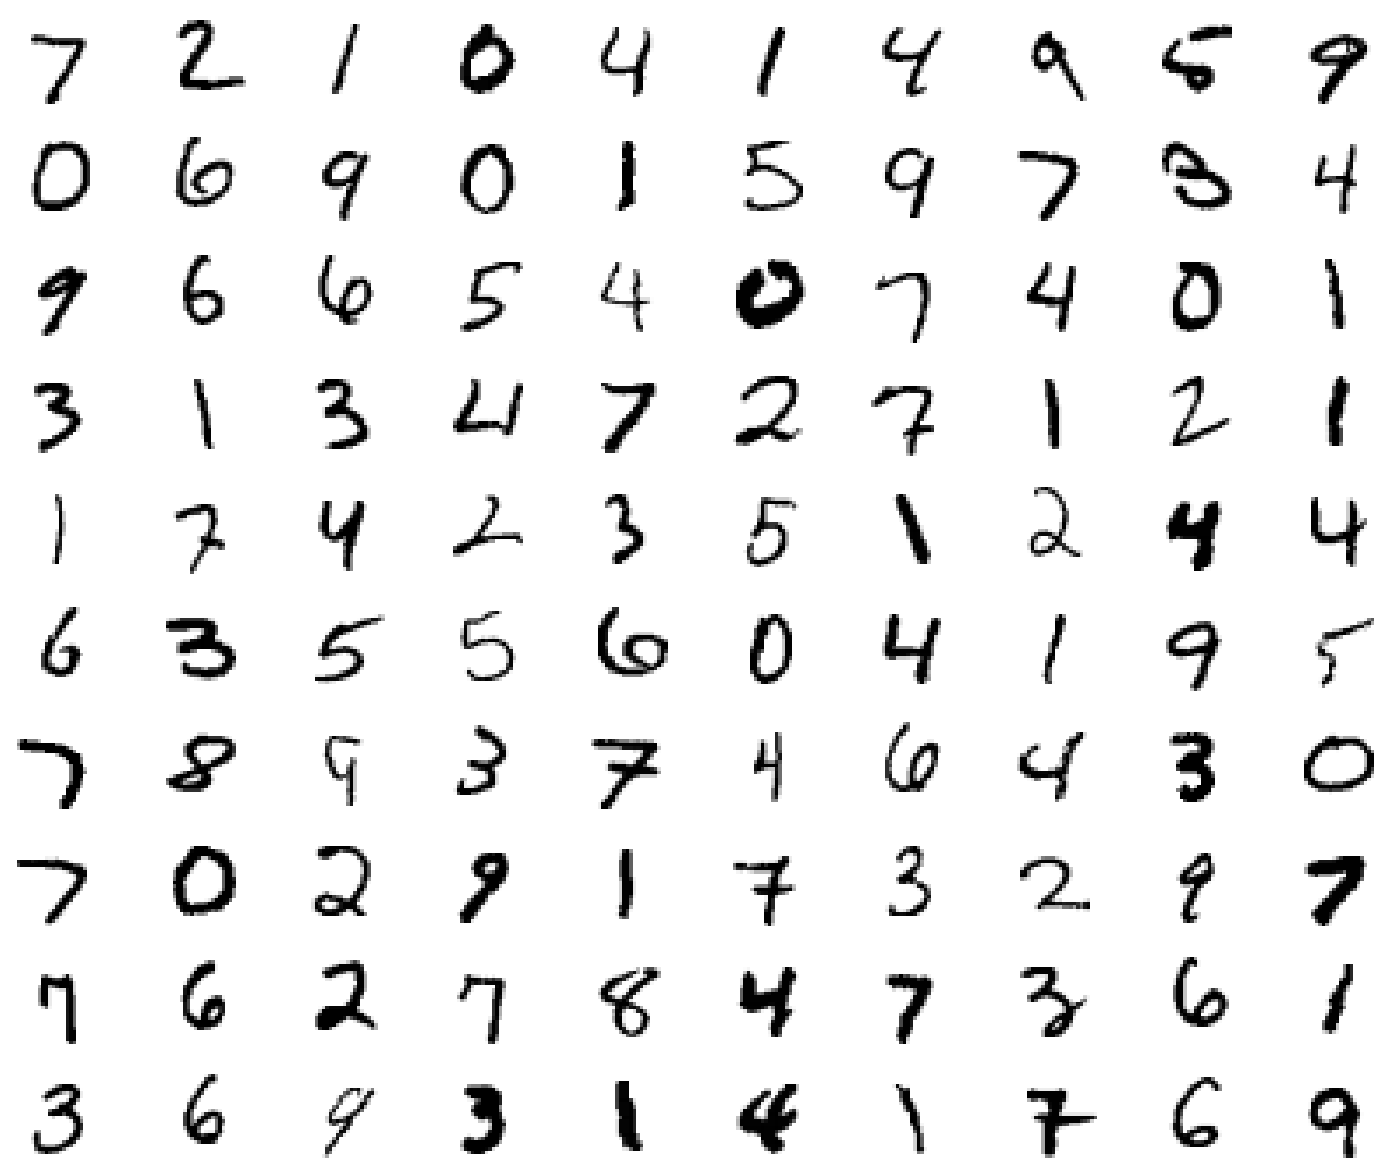

In [135]:
import matplotlib.pyplot as plt

# Function to plot multiple digit images from the dataset
def plot_digit(image_arrays):
    # Reshape each image array (1D) back into a 28x28 image (2D)
    image_list = [item.reshape(28, 28) for item in image_arrays]
    
    # Determine the number of images and the layout of the plot
    images_num  = len(image_list)
    rows_num = images_num // 10 + (1 if images_num % 10 else 0)  # Ensure at least one row for leftover images

    # Create subplots grid (rows_num x 10), with each plot sized appropriately
    fig, axes = plt.subplots(rows_num , 10, figsize=(18, rows_num*1.5))
    axes = axes.ravel()  # Flatten the axes array for easier iteration

    # Display each image in its corresponding subplot
    for index in range(images_num):
        axes[index].imshow(image_list[index], cmap='binary')  # Display the image in grayscale (binary)
        axes[index].axis('off')  # Turn off axis labels for clarity

    # Show the plot
    plt.show()

# Plot the first 100 images from the test set
plot_digit(X_test[:100])

## Utility Function to Display the Confusion Matrices

### The function takes in a confusion matrix (cm), class names for labels, and optional parameters for the title and color map (cmap).
### The heatmap visually represents the confusion matrix with annotations, where the values inside each cell correspond to the number of instances classified in that cell.
### The axis labels show true vs. predicted labels to make the matrix easier to interpret.

In [136]:
from matplotlib import pyplot as plt
import seaborn as sns

# Function to plot the confusion matrix with a heatmap
def plot_confusion_matrix(cm, class_names, title='', cmap='Blues'):
    # Create a figure for the plot
    plt.figure(figsize=(8, 6))

    # Use seaborn to plot the heatmap of the confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, cbar=True, 
                xticklabels=class_names, yticklabels=class_names)

    # Set title and axis labels
    plt.title(title, fontsize=16)
    plt.xlabel('Predicted Labels', fontsize=14)
    plt.ylabel('True Labels', fontsize=14)

    # Show the plot
    plt.show()

## Defining Cross-Validation and Metric Computation for Classifier Evaluation

### This section sets up the cross-validation method and a utility function to compute evaluation metrics (accuracy, precision, recall, and F1 score) along with confusion matrix visualization.

In [137]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Create an empty list to store results for each classifier
results = []

# Define StratifiedKFold for cross-validation (ensures balanced class distribution in folds)
cv = StratifiedKFold(n_splits=3)

# Function to compute accuracy, precision, recall, F1 score, and plot confusion matrix
def compute_metrics(y_true, y_pred):

    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix using the previously defined function
    labels = [f'{label}' for label in range(10)]  # MNIST classes (digits 0-9)
    plot_confusion_matrix(conf_matrix, class_names=labels)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision_weighted = precision_score(y_true, y_pred, average='weighted')
    recall_weighted = recall_score(y_true, y_pred, average='weighted')
    f1_score_weighted = f1_score(y_true, y_pred, average='weighted')

    # Return a dictionary of the computed metrics
    return {
        'accuracy': accuracy,
        'precision': precision_weighted,
        'recall': recall_weighted, 
        'f1_score': f1_score_weighted
    }

## Hyperparameter Tuning and Evaluation for SVC Classifiers

### Hyperparameter Tuning and Evaluation for Linear SVC Classifier

#### Hyperparameter Grid: The grid specifies different values for the C parameter, which controls the trade-off between achieving a low training error and a low testing error.
#### GridSearchCV: This tool automates the process of hyperparameter tuning by performing cross-validation for each combination of parameters specified in the grid.
#### Evaluation Metrics: After fitting the model, predictions are made on the training set, and performance metrics are computed and stored for later comparison with other classifiers.
#### The metrics are printed at the end to provide immediate feedback on the model's performance.

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END ..............................................C=0.1; total time= 7.9min
[CV] END ..............................................C=0.1; total time= 7.7min
[CV] END ..............................................C=0.1; total time= 7.4min
[CV] END ................................................C=1; total time= 8.0min
[CV] END ................................................C=1; total time= 7.8min
[CV] END ................................................C=1; total time= 7.7min
[CV] END ...............................................C=10; total time= 9.2min
[CV] END ...............................................C=10; total time= 8.8min
[CV] END ...............................................C=10; total time= 8.5min


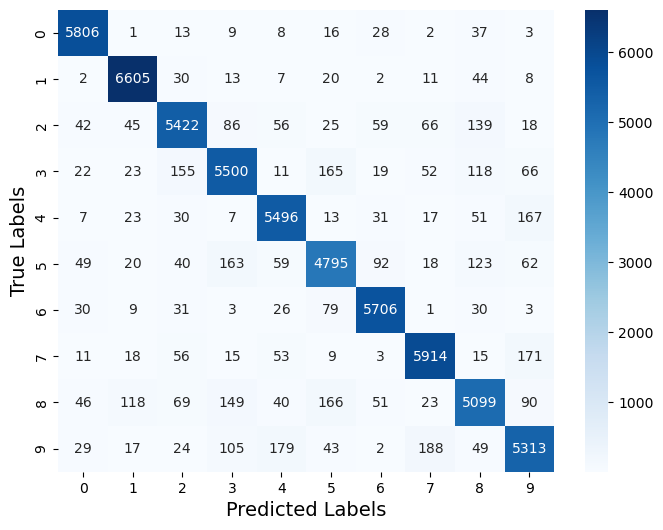

{'Kernel': 'linear', 'Best Parameters': {'C': 1}, 'Accuracy': 0.9276, 'Precision': np.float64(0.927248236620482), 'Recall': np.float64(0.9276), 'F1 Score': np.float64(0.9273634655850697)}


In [25]:
# Define the hyperparameter grid for the linear kernel
linear_param_grid = [{'C': [0.1, 1, 10]}]  # Range of C values to test for regularization strength

# Create the LinearSVC model with a maximum of 200,000 iterations
linear_svc = LinearSVC(max_iter=200000, random_state=42)

# Create the GridSearchCV object for linear kernel
linear_grid_search = GridSearchCV(
    linear_svc,
    param_grid=linear_param_grid,  # Hyperparameter grid
    cv=cv,                          # Cross-validation strategy
    scoring='f1_weighted',         # Metric to optimize
    return_train_score=True,       # Include training scores in results
    verbose=2                       # Print detailed output during fitting
)

# Fit the model for the linear kernel with training data
linear_grid_search.fit(X_train, y_train)

# Retrieve the best hyperparameters found during the search
best_linear_params = linear_grid_search.best_params_

# Make predictions on the training data
y_pred_linear = linear_grid_search.predict(X_train)

# Compute evaluation metrics using the predictions
linear_metrics = compute_metrics(y_train, y_pred_linear)

# Extract individual metrics for clarity
accuracy_linear = linear_metrics['accuracy']
precision_linear = linear_metrics['precision']
recall_linear = linear_metrics['recall']
f1_score_linear = linear_metrics['f1_score']

# Store results for linear kernel in a dictionary
linear_metrics = {
    'Kernel': 'linear',
    'Best Parameters': best_linear_params,
    'Accuracy': accuracy_linear,
    'Precision': precision_linear,
    'Recall': recall_linear,
    'F1 Score': f1_score_linear
}

# Append the results to the results list
results.append(linear_metrics)

# Print the metrics for the linear kernel
print(linear_metrics)

### Hyperparameter Tuning and Evaluation for RBF SVC Classifier

#### Hyperparameter Grid: The grid includes different values for the C parameter and options for gamma, which defines the influence of a single training example. Using 'scale' or 'auto' helps in adjusting gamma based on the data distribution.
#### GridSearchCV: Similar to the previous section, this automates the tuning process for the RBF kernel.
#### Evaluation Metrics: The predicted values on the training set are used to compute the performance metrics, which are then stored for comparison with other classifiers.


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END .................................C=0.1, gamma=scale; total time= 4.7min
[CV] END .................................C=0.1, gamma=scale; total time= 4.7min
[CV] END .................................C=0.1, gamma=scale; total time= 4.7min
[CV] END ..................................C=0.1, gamma=auto; total time=24.7min
[CV] END ..................................C=0.1, gamma=auto; total time=24.6min
[CV] END ..................................C=0.1, gamma=auto; total time=24.7min
[CV] END ...................................C=1, gamma=scale; total time= 2.4min
[CV] END ...................................C=1, gamma=scale; total time= 2.4min
[CV] END ...................................C=1, gamma=scale; total time= 2.5min
[CV] END ....................................C=1, gamma=auto; total time=26.1min
[CV] END ....................................C=1, gamma=auto; total time=26.1min
[CV] END ....................................C=1,

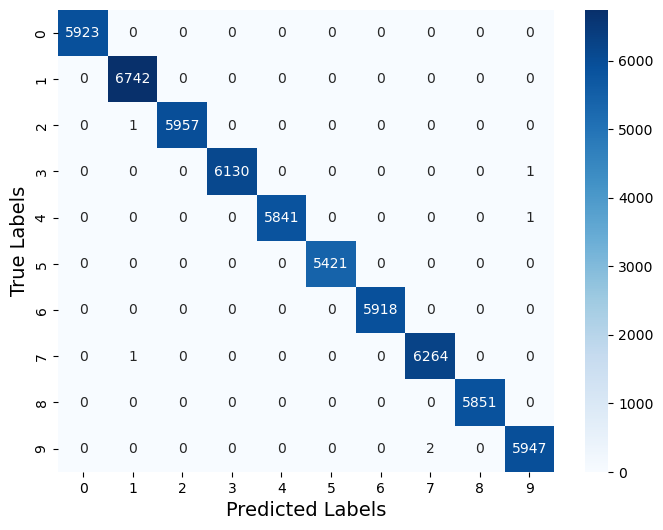

{'Kernel': 'rbf', 'Best Parameters': {'C': 10, 'gamma': 'scale'}, 'Accuracy': 0.9999, 'Precision': np.float64(0.999900015205045), 'Recall': np.float64(0.9999), 'F1 Score': np.float64(0.9999000023744039)}


In [26]:
# Define the hyperparameter grid for the RBF kernel
rbf_param_grid = [
    {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}  # Range of C values and gamma settings
]

# Create the SVC model with the RBF kernel
rbf_svc = SVC(random_state=42, kernel='rbf')  # Random state for reproducibility

# Create the GridSearchCV object for RBF kernel
rbf_grid_search = GridSearchCV(
    rbf_svc,
    param_grid=rbf_param_grid,  # Hyperparameter grid for tuning
    cv=cv,                       # Cross-validation strategy
    scoring='f1_weighted',      # Metric to optimize
    return_train_score=True,    # Include training scores in results
    verbose=2                    # Print detailed output during fitting
)

# Fit the model for the RBF kernel with training data
rbf_grid_search.fit(X_train, y_train)

# Retrieve the best hyperparameters found during the search
best_rbf_params = rbf_grid_search.best_params_

# Make predictions on the training data
y_pred_rbf_train = rbf_grid_search.predict(X_train)

# Compute evaluation metrics using the predictions
rbf_metrics = compute_metrics(y_train, y_pred_rbf_train)

# Extract individual metrics for clarity
accuracy_rbf = rbf_metrics['accuracy']
precision_rbf = rbf_metrics['precision']
recall_rbf = rbf_metrics['recall']
f1_rbf = rbf_metrics['f1_score']

# Store results for RBF kernel in a dictionary
rbf_metrics = {
    'Kernel': 'rbf',
    'Best Parameters': best_rbf_params,
    'Accuracy': accuracy_rbf,
    'Precision': precision_rbf,
    'Recall': recall_rbf,
    'F1 Score': f1_rbf
}

# Append the results to the results list
results.append(rbf_metrics)

# Print the metrics for the RBF kernel
print(rbf_metrics)

### Hyperparameter Tuning and Evaluation for Polynomial SVC Classifier


#### Hyperparameter Grid: This grid includes different values for the C parameter, the degree of the polynomial kernel, and the coef0 term, which allows tuning of the influence of higher-order versus lower-order terms.
#### GridSearchCV: This automates the hyperparameter tuning process for the Polynomial kernel, similar to previous sections.
#### Evaluation Metrics: The computed metrics provide a comprehensive evaluation of the model's performance on the training set.

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END ...........................C=0.1, coef0=0, degree=2; total time= 3.0min
[CV] END ...........................C=0.1, coef0=0, degree=2; total time= 2.9min
[CV] END ...........................C=0.1, coef0=0, degree=2; total time= 2.9min
[CV] END ...........................C=0.1, coef0=0, degree=3; total time= 3.2min
[CV] END ...........................C=0.1, coef0=0, degree=3; total time= 3.2min
[CV] END ...........................C=0.1, coef0=0, degree=3; total time= 3.4min
[CV] END ...........................C=0.1, coef0=1, degree=2; total time= 2.3min
[CV] END ...........................C=0.1, coef0=1, degree=2; total time= 2.1min
[CV] END ...........................C=0.1, coef0=1, degree=2; total time= 2.2min
[CV] END ...........................C=0.1, coef0=1, degree=3; total time= 1.6min
[CV] END ...........................C=0.1, coef0=1, degree=3; total time= 1.6min
[CV] END ...........................C=0.1, coef0

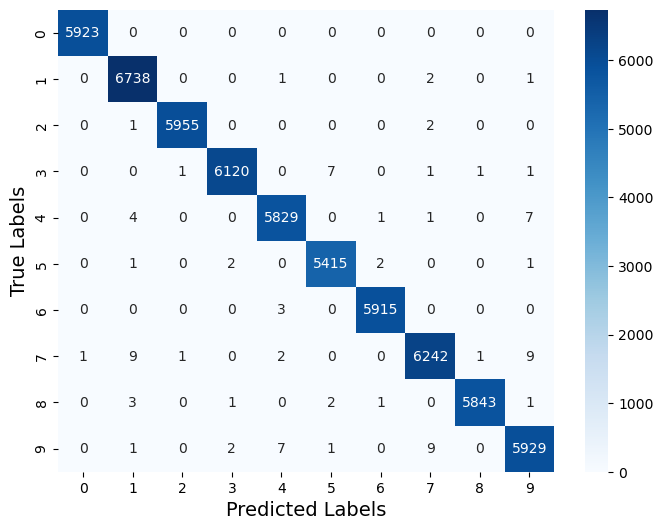

{'Kernel': 'poly', 'Best Parameters': {'C': 1, 'coef0': 1, 'degree': 3}, 'Accuracy': 0.9984833333333333, 'Precision': np.float64(0.9984837321848777), 'Recall': np.float64(0.9984833333333333), 'F1 Score': np.float64(0.9984832872854082)}


In [27]:
# Define the hyperparameter grid for the Polynomial kernel
poly_param_grid = [
    {'C': [0.1, 1, 10], 'degree': [2, 3], 'coef0': [0, 1]}  # Values for C, degree of polynomial, and coef0
]

# Create the SVC model with the Polynomial kernel
poly_svc = SVC(random_state=42, kernel='poly')  # Random state for reproducibility

# Create the GridSearchCV object for Polynomial kernel
poly_grid_search = GridSearchCV(
    poly_svc,
    param_grid=poly_param_grid,  # Hyperparameter grid for tuning
    cv=cv,                        # Cross-validation strategy
    scoring='f1_weighted',       # Metric to optimize
    return_train_score=True,     # Include training scores in results
    verbose=2                     # Print detailed output during fitting
)

# Fit the model for the Polynomial kernel with training data
poly_grid_search.fit(X_train, y_train)

# Retrieve the best hyperparameters found during the search
best_poly_params = poly_grid_search.best_params_

# Make predictions on the training data
y_pred_poly_train = poly_grid_search.predict(X_train)

# Compute evaluation metrics using the predictions
poly_metrics = compute_metrics(y_train, y_pred_poly_train)

# Extract individual metrics for clarity
accuracy_poly = poly_metrics['accuracy']
precision_poly = poly_metrics['precision']
recall_poly = poly_metrics['recall']
f1_score_poly = poly_metrics['f1_score']

# Store results for Polynomial kernel in a dictionary
poly_metrics = {
    'Kernel': 'poly',
    'Best Parameters': best_poly_params,
    'Accuracy': accuracy_poly,
    'Precision': precision_poly,
    'Recall': recall_poly,
    'F1 Score': f1_score_poly
}

# Append the results to the results list
results.append(poly_metrics)

# Print the metrics for the Polynomial kernel
print(poly_metrics)

## Evaluating and Comparing the Models

### Classifier Evaluation Utility for Training, Cross-Validation, and Test Performance

#### This code defines a ClassifierEvaluator class for evaluating classifiers using various metrics, including accuracy, precision, recall, and F1 score. It incorporates cross-validation and allows for the evaluation of training and test datasets.
#### ClassifierEvaluator Class: This class is designed to streamline the evaluation of classifiers across three datasets—training, cross-validation, and testing. It ensures that key metrics are computed for each phase and organizes the results into a DataFrame for easy comparison.
#### Cross-validation and Metrics: It computes cross-validation scores for various metrics and uses weighted averages to handle class imbalances.
#### Timing: Training and prediction times are recorded and formatted for readability.

In [138]:
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate, StratifiedKFold
from time import time
from sklearn.base import BaseEstimator
import numpy as np
import pandas as pd
from typing import Optional, Dict, Any

class ClassifierEvaluator:
    """
    A class to evaluate classifiers on training, cross-validation, and test datasets.

    Attributes:
        X_train: Training feature set.
        y_train: Training labels.
        X_test: Test feature set.
        y_test: Test labels.
        metrics: List to store evaluation metrics.
        heads: Column headers for metrics DataFrame.
        cv_scoring: Dictionary defining scoring metrics for cross-validation.
        scores: List of scoring metric names.
        cv_metrics: List to store cross-validation metrics.
    """
    
    def __init__(self, X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray, y_test: np.ndarray):
        # Initialize data and metrics storage
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.metrics = []
        self.heads = ['Classifier', 'Phase', 'Training Time', 'Accuracy Score', 'Precision Score', 'Recall Score', 'F1 Score']
        
        # Define scoring metrics for cross-validation
        self.cv_scoring = {
            'accuracy': 'accuracy',
            'precision': make_scorer(precision_score, average='weighted'),
            'recall': make_scorer(recall_score, average='weighted'),
            'f1_score': make_scorer(f1_score, average='weighted')
        }
        self.scores = list(self.cv_scoring.keys())
        self.cv_metrics = []

    def _new_section(self, name: str, total_chars: int = 70) -> None:
        """Print a new section header for evaluation output."""
        name_length = len(name)
        dash_count = (total_chars - name_length - len(" Evaluation")) // 2
        dyn_line = f"\n{'-' * dash_count}{name} Evaluation{'-' * dash_count}"
        print(dyn_line)

    def _format_time(self, seconds: float) -> str:
        """Format a time duration in seconds into a readable string."""
        # Convert seconds into hours, minutes, seconds, and milliseconds
        hours = int(seconds // 3600)
        minutes = int((seconds % 3600) // 60)
        secs = int(seconds % 60)
        milliseconds = int((seconds * 1000) % 1000)

        # Return formatted string
        time_str = ""
        if hours > 0:
            time_str += f"{hours}h "
        if minutes > 0 or hours > 0:
            time_str += f"{minutes}m "
        if secs > 0 or minutes > 0 or hours > 0:
            time_str += f"{secs}s "
        if milliseconds > 0 or (hours == 0 and minutes == 0 and secs == 0):
            time_str += f"{milliseconds}ms"
        
        return time_str.strip()

    def evaluate_classifier(self, classifier: BaseEstimator, cv: int = 3) -> None:
        """Fit the classifier and evaluate its performance on training, cross-validation, and test datasets."""
        name = classifier.__class__.__name__
        if hasattr(classifier, 'kernel'):
            name += f" {classifier.kernel.capitalize()}"
        self._new_section(name, total_chars=90)
        
        # Fit classifier on training set and record training time
        print(f"Fitting {name}...")
        training_start = time()
        classifier.fit(self.X_train, self.y_train)
        training_finish = time()
        training_duration = training_finish - training_start

        # Evaluate the model on training, cross-validation, and test sets
        self._evaluate_training(classifier, name, training_duration)
        self._evaluate_cross_validation(classifier, cv, name)
        self._evaluate_test_set(classifier, name)

    def _evaluate(self, classifier: BaseEstimator, X: np.ndarray, y: np.ndarray, name: str = '') -> Optional[Dict[str, Any]]:
        """Evaluate the classifier on a given dataset."""
        y_pred = classifier.predict(X)
        return self._compute_scores(y, y_pred, name=name)

    def _compute_scores(self,
                        y_true: np.ndarray,
                        y_pred: Optional[np.ndarray] = None,
                        classifier: Optional[BaseEstimator] = None,
                        cv: int = 0,
                        name: str = '') -> Optional[Dict[str, float]]:
        """Compute evaluation scores based on true and predicted labels."""
        result = None
        if y_pred is not None:
            # Compute standard classification metrics
            _accuracy = accuracy_score(y_true, y_pred)
            _precision = precision_score(y_true, y_pred, average='weighted')
            _recall = recall_score(y_true, y_pred, average='weighted')
            _f1_score = f1_score(y_true, y_pred, average='weighted')
            result = {
                'accuracy': _accuracy,
                'precision': _precision,
                'recall': _recall,
                'f1_score': _f1_score
            }
            print(f"{name}: accuracy={_accuracy*100:.2f}%, precision={_precision*100:.2f}%, recall={_recall*100:.2f}%, f1_score={_f1_score*100:.2f}%")
        elif classifier and name:  # Cross-validation metrics
            self.cv = StratifiedKFold(n_splits=cv or 3)
            cv_scores = cross_validate(classifier, self.X_train, self.y_train, cv=self.cv, scoring=self.cv_scoring)
            result = {
                'accuracy': cv_scores['test_accuracy'].mean(),
                'precision': cv_scores['test_precision'].mean(),
                'recall': cv_scores['test_recall'].mean(),
                'f1_score': cv_scores['test_f1_score'].mean()
            }
            print(f'CV scores: accuracy={result["accuracy"]*100:.2f}%, precision={result["precision"]*100:.2f}%, recall={result["recall"]*100:.2f}%, f1_score={result["f1_score"]*100:.2f}%')
        return result

    def _evaluate_training(self, classifier: BaseEstimator, name: str, training_duration: float) -> None:
        """Evaluate the classifier's performance on the training dataset."""
        print("Evaluating training scores...")
        prediction_start = time()
        y_pred = classifier.predict(self.X_train)
        prediction_finish = time()
        prediction_duration = prediction_finish - prediction_start
        time_metrics = training_duration + prediction_duration

        print(f"Training (and prediction) time for {name}: {self._format_time(time_metrics)}")
        
        print(f'Training scores: ', end='')
        training_scores = self._compute_scores(self.y_train, y_pred)
        
        if training_scores:
            self.metrics.append([name, 'Train', self._format_time(time_metrics)] +
                                [training_scores[key] for key in self.scores])

    def _evaluate_cross_validation(self, classifier: BaseEstimator, cv: int, name: str) -> None:
        """Evaluate the classifier's performance using cross-validation."""
        print('Evaluating cross-validation (CV) scores...')
        cv_scores = self._compute_scores(y_true=self.y_train, classifier=classifier, name=name)
        if cv_scores:
            cv_metrics = [name, 'Cross-Val.', pd.NA] + [cv_scores[score_name] for score_name in self.scores]
            self.cv_metrics.append(cv_metrics)

    def _evaluate_test_set(self, classifier: BaseEstimator, name: str) -> None:
        """Evaluate the classifier's performance on the test dataset."""
        print('Evaluating test scores...')
        y_pred = classifier.predict(self.X_test)
        print(f'Test scores: ', end='')
        test_scores = self._compute_scores(self.y_test, y_pred)
        if test_scores:
            self.metrics.append([name, 'Test', pd.NA] +
                                [test_scores[score_name] for score_name in self.scores])

    def get_all_metrics(self) -> pd.DataFrame:
        """Compile and return all collected evaluation metrics as a DataFrame."""
        training_df = pd.DataFrame(self.metrics, columns=self.heads)
        cross_val_df = pd.DataFrame(self.cv_metrics, columns=self.heads[:3] + ['Training Time'] + self.scores)
        all_metrics_df = pd.concat([training_df, cross_val_df], ignore_index=True)
        return all_metrics_df

In [139]:
# Initializing the Model Evaluator on the mnist dataset (version 1
model_evaluator = ClassifierEvaluator(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

#### To evaluate the computational efficiency of the classifiers, it is important to measure the total time taken from the execution of the fit method to the end of the prediction phase. This approach provides a comprehensive view of the performance of each classifier, as it captures both the preparation time during fitting and the computational effort during prediction. While classifiers like KNeighbors primarily store the training data during fitting, making that phase less informative on its own, the prediction phase involves calculating distances and determining nearest neighbors, which can be computationally intensive. By analyzing the combined time for fitting and prediction across various classifiers, valuable insights can be gained regarding their overall performance and suitability for specific applications.

### Evaluating and Comparing the Models

#### Classifier Initialization: Multiple classifiers are created with specific hyperparameters based on previous tuning.
#### evaluate_classifier(): This method is called for each classifier, performing training, cross-validation, and test evaluation.
#### Metrics Collection: The evaluation results for each classifier are stored and will be available in the consolidated metrics DataFrame.

In [140]:
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier



# Initialize the ClassifierEvaluator
model_evaluator = ClassifierEvaluator(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)



linear_svc = LinearSVC(random_state=42, max_iter=200000)
rbf_svc = SVC(kernel='rbf', C=10, gamma='scale')
poly_svc = SVC(kernel='poly', C=1, coef0=1, degree=3)
neigh_clf = KNeighborsClassifier(n_neighbors=4, weights='distance')
sgd_clf = SGDClassifier(alpha=0.0001, loss='log_loss', max_iter=2000, random_state=42)
rf_clf = RandomForestClassifier(max_depth=20, max_features='sqrt', n_estimators=400, random_state=42)

models = [linear_svc, rbf_svc, poly_svc, neigh_clf, rf_clf, sgd_clf]
for model in models:
    model_evaluator.evaluate_classifier(model)


-----------------------------------LinearSVC Evaluation-----------------------------------
Fitting LinearSVC...
Evaluating training scores...
Training (and prediction) time for LinearSVC: 10m 43s 360ms
Training scores: : accuracy=92.76%, precision=92.72%, recall=92.76%, f1_score=92.74%
Evaluating cross-validation (CV) scores...
CV scores: LinearSVC: accuracy=90.75%, precision=90.72%, recall=90.75%, f1_score=90.73%
Evaluating test scores...
Test scores: : accuracy=91.69%, precision=91.66%, recall=91.69%, f1_score=91.66%

------------------------------------SVC Rbf Evaluation------------------------------------
Fitting SVC Rbf...
Evaluating training scores...
Training (and prediction) time for SVC Rbf: 5m 36s 337ms
Training scores: : accuracy=99.99%, precision=99.99%, recall=99.99%, f1_score=99.99%
Evaluating cross-validation (CV) scores...
CV scores: SVC Rbf: accuracy=98.02%, precision=98.02%, recall=98.02%, f1_score=98.02%
Evaluating test scores...
Test scores: : accuracy=98.37%, prec

#### Displaying Collected Evaluation Metrics

In [141]:
model_evaluator.get_all_metrics()

,Classifier,Phase,Training Time,Accuracy Score,Precision Score,Recall Score,F1 Score
0,KNeighborsClassifier,Train,50s 835ms,100.00%,100.00%,100.00%,100.00%
1,LinearSVC,Train,10m 43s 360ms,92.76%,92.72%,92.76%,92.74%
2,RandomForestClassifier,Train,1m 31s 224ms,99.93%,99.93%,99.93%,99.93%
3,SGDClassifier,Train,57s 578ms,89.13%,90.12%,89.13%,89.16%
4,SVC Poly,Train,3m 34s 195ms,99.85%,99.85%,99.85%,99.85%
5,SVC Rbf,Train,5m 36s 337ms,99.99%,99.99%,99.99%,99.99%
6,KNeighborsClassifier,Cross-Val.,<NA>,97.04%,97.05%,97.04%,97.03%
7,LinearSVC,Cross-Val.,<NA>,90.75%,90.72%,90.75%,90.73%
8,RandomForestClassifier,Cross-Val.,<NA>,96.61%,96.61%,96.61%,96.61%
9,SGDClassifier,Cross-Val.,<NA>,87.67%,88.39%,87.67%,87.75%


### Visualization

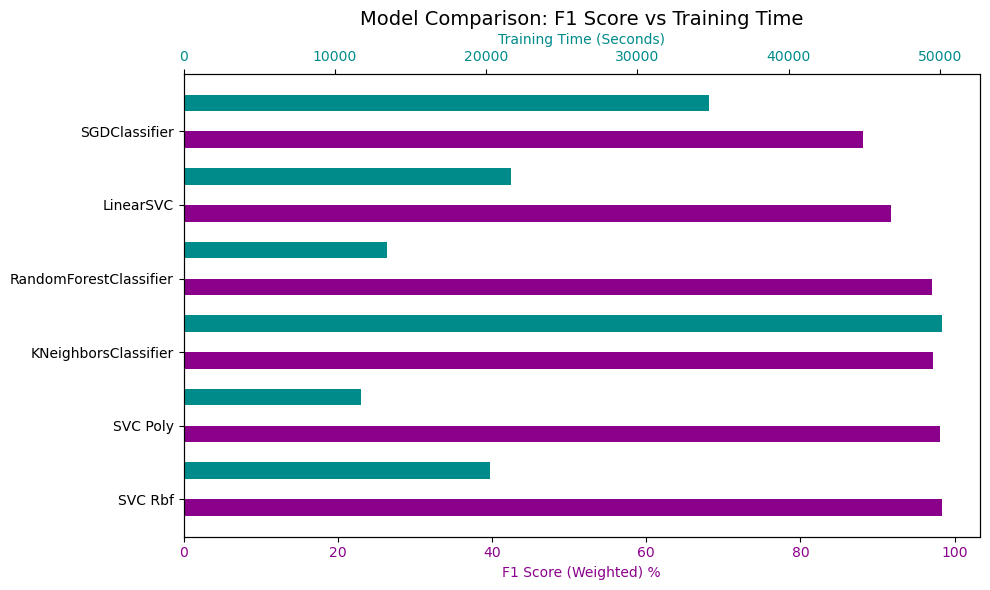

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

# Data from your evaluation result
data = {
    'Model': ['KNeighborsClassifier', 'LinearSVC', 'RandomForestClassifier', 'SGDClassifier', 'SVC Poly', 'SVC Rbf'],
    'F1_Score': [97.14, 91.69, 97.05, 88.17, 98.13, 98.37],  # F1 Scores (weighted) for test set
    'Training_Time': ['50s 835ms', '10m 43s 360ms', '1m 31s 224ms', '57s 578ms', '3m 34s 195ms', '5m 36s 337ms']  # Training times
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Function to convert time to seconds, handling hours, minutes, seconds, and milliseconds
def time_to_seconds(time_str):
    hours = minutes = seconds = milliseconds = 0

    # Regular expression to capture h, m, s, and ms
    time_regex = re.findall(r'(\d+)(h|m|s|ms)', time_str)
    for value, unit in time_regex:
        if unit == 'h':
            hours = int(value)
        elif unit == 'm':
            minutes = int(value)
        elif unit == 's':
            seconds = int(value)
        elif unit == 'ms':
            milliseconds = int(value)

    # Calculate total time in seconds
    total_seconds = hours * 3600 + minutes * 60 + seconds + milliseconds / 1000
    return total_seconds

# Apply the time conversion
df['Training_Time_Sec'] = df['Training_Time'].apply(time_to_seconds)

# Sort by F1 Score
df_sorted = df.sort_values(by='F1_Score', ascending=False)

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Number of models
num_models = len(df_sorted)

# Adjust positions so that the time bar is directly below the score bar for each model
y_positions = np.arange(num_models * 2)  # Two bars per model (for F1 score and time)

# Set bar height (slightly wider than before but not default)
bar_height = 0.45

# Plot F1 Scores (magenta, slightly darker, bars)
ax1.barh(y_positions[::2], df_sorted['F1_Score'], color='darkmagenta', height=bar_height, label='F1 Score (Weighted)')
ax1.set_xlabel('F1 Score (Weighted) %', color='darkmagenta')
ax1.tick_params(axis='x', labelcolor='darkmagenta')
ax1.set_yticks(y_positions[::2] + bar_height / 2)  # Center y-ticks on F1 score bars
ax1.set_yticklabels(df_sorted['Model'])

# Create second axis for training time (cyan, slightly darker, bars)
ax2 = ax1.twiny()
ax2.barh(y_positions[1::2], df_sorted['Training_Time_Sec'], color='darkcyan', height=bar_height, label='Training Time (Seconds)')
ax2.set_xlabel('Training Time (Seconds)', color='darkcyan')
ax2.tick_params(axis='x', labelcolor='darkcyan')

# Add space between different models (by adjusting y_positions)
y_positions = np.arange(0, num_models * 2, 2)

# Final styling
plt.title('Model Comparison: F1 Score vs Training Time', fontsize=14)
plt.tight_layout()
plt.show()